# ACCELEROMETER VARIATION

In [244]:
# Import
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import os
import csv
from python_speech_features import mfcc
from python_speech_features import logfbank
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 3]

In [10]:
# Get the root path of the project
#ROOT_DIR = os.path.relpath("../../07_Measure/Outdoor_200924")
ROOT_DIR = os.path.relpath("C:/Temp/MeasureAccDone")
os.chdir(ROOT_DIR)
print(os.getcwd())

C:\Temp\MeasureAccDone


In [11]:
'''
Function : getDataFromFile
Param    : path to file
Return   : data_np -> Numpy array with all data (3 acc x 3 axis)
           hpfEnable -> return if the High Pass Filter was enabled during the measure
           FlowRate -> return the flow rate measured during the test
'''
def getDataFromFile(path):
    data = pd.read_csv(path, index_col=False , sep=';', skiprows=1, header=None)
    data_np = np.array(data, np.float64)

    with open(path) as csvFile:
        reader = csv.reader(csvFile, delimiter=';')
        field_names_list = next(reader)
        #print(field_names_list)
        hpfEnable = False
        if field_names_list[6] == 'HPF_Enable' :
            hpfEnable = True
        flowRate = field_names_list[10]
    
    return data_np, hpfEnable, flowRate

In [171]:
'''
Function : getFeatures
Param    : dx, dy, dz -> numpy data corresponding to the 3 axis
Return   : list of features extracted + flowRate
'''
def getFeatures(dx, dy, dz, flowRate, sig='std', segmentation_level=10):
    
    # Perform a butterworth high-pass filter on the data
    b, a = signal.butter(8, 16, fs=800, btype='highpass')
    zi = signal.lfilter_zi(b, a)
    x_high = signal.lfilter(b, a, dx, zi=None)
    y_high = signal.lfilter(b, a, dy, zi=None)
    z_high = signal.lfilter(b, a, dz, zi=None)
    
    feat = np.sqrt(np.power(x_high,2)+np.power(y_high,2)+np.power(z_high,2))
    if sig == 'mfcc':
        # Extract MFCC features
        sampling_freq = 800
        mfcc_features = mfcc(feat, samplerate=sampling_freq, winlen=1.0)
        feat = mfcc_features[1:, 0]

    if sig == 'fft' :
        feat_fft = np.fft.rfft(feat)
        feat_Norm = np.sqrt(np.power(feat_fft.real,2)+np.power(feat_fft.imag,2))
        feat_Freq = np.fft.rfftfreq(len(feat),d=0.00125)
        feat_Freq = feat_Freq[feat_Freq <= 100] # Limited @ 50
        feat = feat_Norm[1:len(feat_Freq)-1]

    if sig == 'low' : 
        b, a = signal.butter(8, 20, fs=800)
        zi = signal.lfilter_zi(b, a)
        feat = signal.lfilter(b, a, feat, zi=None)

    chunk_size = int(feat.shape[0] / segmentation_level)
    segment_count = 1
    
    features_all_df = pd.DataFrame()
        
    for start in range(0, feat.shape[0], chunk_size):
        feat_subset = feat[start:start + chunk_size]     
        feat_len = len(feat_subset)
        features_df = pd.DataFrame()
        # Minimum
        #features_df['s{:02d}_'.format(segment_count)+sig+'_'+'Min'] = [feat_subset.min()]
        # Maximum
        #features_df['s{:02d}_'.format(segment_count)+sig+'_'+'Max'] = [feat_subset.max()]
        # Min-Max
        features_df['s{:02d}_'.format(segment_count)+sig+'_'+'MinMax'] = [feat_subset.max()-feat_subset.min()]
        # Arithmetic Mean
        feat_am = sum(feat_subset) / feat_len
        features_df['s{:02d}_'.format(segment_count)+sig+'_'+'ArithMean'] = [feat_am]
        # Mean Absolute
        features_df['s{:02d}_'.format(segment_count)+sig+'_'+'MeanAbs'] = [np.abs(sum(feat_subset)) / feat_len]
        # Root Mean Square
        features_df['s{:02d}_'.format(segment_count)+sig+'_'+'RMS'] = [np.sqrt(sum(pow(feat_subset, 2)) / feat_len)]
        # Standard Deviation
        feat_sd = np.sqrt(sum(pow(feat_subset - feat_am, 2)) / feat_len)
        features_df['s{:02d}_'.format(segment_count)+sig+'_'+'StandDev'] = [feat_sd]
        # Skewness
        #feat_sn = sum((feat_subset - feat_am) * 3 / ((feat_len - 1) * pow(feat_sd, 3)))
        #features_df['s{:02d}_'.format(segment_count)+sig+'_'+'Skewness'] = [feat_sn]
        # Kurthosis
        #feat_kt = sum((feat_subset - feat_am) * 4 / ((feat_len - 1) * pow(feat_sd, 4)))
        #features_df['s{:02d}_'.format(segment_count)+sig+'_'+'Kurthosis'] = [feat_kt]
        # Median
        feat_med = np.median(feat_subset)
        features_df['s{:02d}_'.format(segment_count)+sig+'_'+'Median'] = [feat_med]
        # Moment 3th degree
        #feat_mo3 = sum(pow(feat_subset, 3)) / feat_len
        #features_df['s{:02d}_'.format(segment_count)+sig+'_'+'Moment3'] = [feat_mo3]
        # Moment 4th degree
        #feat_mo4 = sum(pow(feat_subset, 4)) / feat_len
        #features_df['s{:02d}_'.format(segment_count)+sig+'_'+'Moment4'] = [feat_mo4]
        # Moment 5th degree
        #feat_mo5 = sum(pow(feat_subset, 5)) / feat_len
        #features_df['s{:02d}_'.format(segment_count)+sig+'_'+'Moment5'] = [feat_mo5]
        # Moment 6th degree
        #feat_mo6 = sum(pow(feat_subset, 6)) / feat_len
        #features_df['s{:02d}_'.format(segment_count)+sig+'_'+'Moment6'] = [feat_mo6]
        
        features_all_df = pd.concat([features_all_df, features_df], axis=1, sort=False)
        
        segment_count += 1
        if segment_count > segmentation_level:
            break

    return features_all_df

In [243]:
'''
Function : extractFeatures
Param    : directory -> files directory
           file -> file to extract
           seg -> nb of segment
Return   : list of features extracted + flowRate
'''
def extractFeatures(directory, file, seg):
    dataset_std = pd.DataFrame()
    dataset_hpf = pd.DataFrame()
    data_np, hpfEnable, flowRate = getDataFromFile(directory + file)    

    std_features = pd.DataFrame()

    std_acc1 = getFeatures(data_np[0,:], data_np[1,:], data_np[2,:], flowRate, sig='std', segmentation_level=seg)
    std_acc1.rename(index={0:'Acc1'}, inplace=True)
    std_acc2 = getFeatures(data_np[3,:], data_np[4,:], data_np[5,:], flowRate, sig='std', segmentation_level=seg)
    std_acc2.rename(index={0:'Acc2'}, inplace=True)
    std_acc3 = getFeatures(data_np[6,:], data_np[7,:], data_np[8,:], flowRate, sig='std', segmentation_level=seg)
    std_acc3.rename(index={0:'Acc3'}, inplace=True)
    std_features = pd.concat([std_acc1, std_acc2, std_acc3], axis=0, sort=False)
    '''
    fft_features = pd.DataFrame()
    fft_acc1 = getFeatures(data_np[0,:], data_np[1,:], data_np[2,:], flowRate, sig='fft', segmentation_level=seg)
    fft_acc1.rename(index={0:'Acc1'}, inplace=True)
    fft_acc2 = getFeatures(data_np[3,:], data_np[4,:], data_np[5,:], flowRate, sig='fft', segmentation_level=seg)
    fft_acc2.rename(index={0:'Acc2'}, inplace=True)
    fft_acc3 = getFeatures(data_np[6,:], data_np[7,:], data_np[8,:], flowRate, sig='fft', segmentation_level=seg)
    fft_acc3.rename(index={0:'Acc3'}, inplace=True)
    fft_features = pd.concat([fft_acc1, fft_acc2, fft_acc3], axis=0, sort=False)

    low_features = pd.DataFrame()
    low_acc1 = getFeatures(data_np[0,:], data_np[1,:], data_np[2,:], flowRate, sig='low', segmentation_level=seg)
    low_acc1.rename(index={0:'Acc1'}, inplace=True)
    low_acc2 = getFeatures(data_np[3,:], data_np[4,:], data_np[5,:], flowRate, sig='low', segmentation_level=seg)
    low_acc2.rename(index={0:'Acc2'}, inplace=True)
    low_acc3 = getFeatures(data_np[6,:], data_np[7,:], data_np[8,:], flowRate, sig='low', segmentation_level=seg)
    low_acc3.rename(index={0:'Acc3'}, inplace=True)
    low_features = pd.concat([low_acc1, low_acc2, low_acc3], axis=0, sort=False)

    subject_features = pd.DataFrame()
    subject_features = pd.concat([std_features, fft_features, low_features], axis=1, sort=False)
    if hpfEnable :
        dataset_hpf = dataset_hpf.append(subject_features)
    else :
        dataset_std = dataset_std.append(subject_features)
    '''
    #subject_features = pd.DataFrame()
    #subject_features = pd.concat([std_features, fft_features], axis=1, sort=True)
    #subject_features = subject_features.sort_index(axis = 1)
    dataset_hpf = dataset_std.append(std_features)
    dataset_std = dataset_std.append(std_features)
    return dataset_hpf, dataset_std


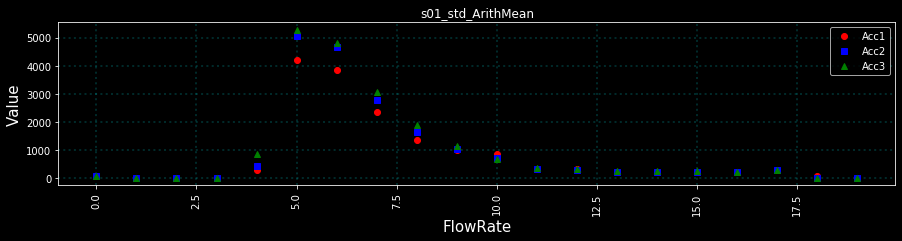

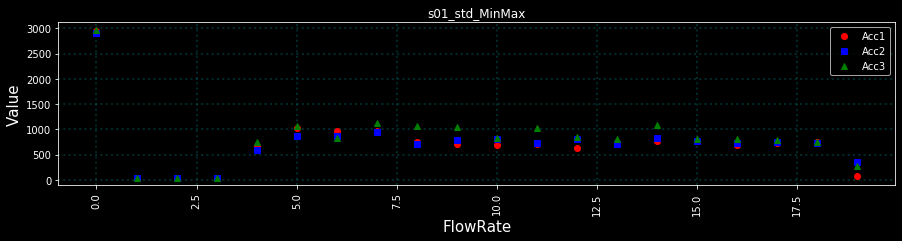

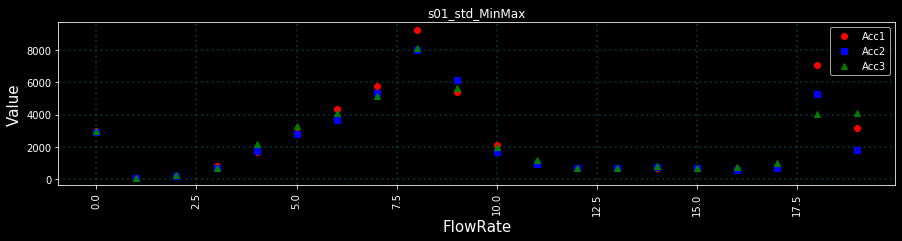

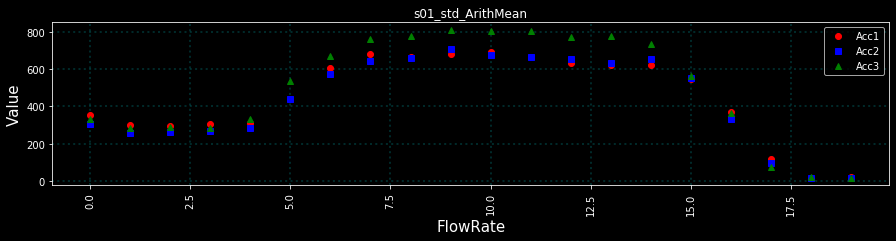

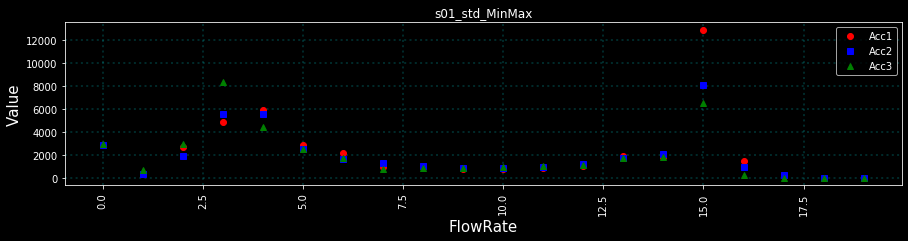

In [247]:
'''
Function : plotDataset
Param    : Dataset to display
Return   : None
'''
def plotDataset(dataset, segmentation=10):
    axis_x = np.arange(segmentation)

    total_feat = int(dataset.shape[1]/segmentation)
    for i in range (0,total_feat) :
        plot_acc1 = dataset.loc['Acc1']
        plot_acc2 = dataset.loc['Acc2']
        plot_acc3 = dataset.loc['Acc3']
        
        data_acc1 = []
        data_acc2 = []
        data_acc3 = []
        
        for j in range (i,dataset.shape[1], total_feat):
            data_acc1 = np.append(data_acc1, plot_acc1.iloc[j])
            data_acc2 = np.append(data_acc2, plot_acc2.iloc[j])
            data_acc3 = np.append(data_acc3, plot_acc3.iloc[j])
        if data_acc1.shape[0] == segmentation :    
            if dataset.columns.values[i] == 's01_std_ArithMean' or dataset.columns.values[i] == 's01_std_MinMax':
                plt.plot(axis_x, data_acc1, 'ro',
                         axis_x, data_acc2, 'bs',
                         axis_x, data_acc3, 'g^')
                plt.legend(['Acc1', 'Acc2', 'Acc3'])
                plt.title(dataset.columns.values[i])
                plt.xlabel('FlowRate', fontsize=15)
                plt.xticks(rotation=90)
                plt.ylabel('Value', fontsize=15)
                plt.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
                plt.show()
    
segmentation = 20
directory = "Meas_acc_flow/"
list_meas_1 = os.listdir(directory)
for file in list_meas_1:
    dataset_hpf, dataset_diff= extractFeatures(directory, file, segmentation)

    plotDataset(dataset_diff, segmentation)

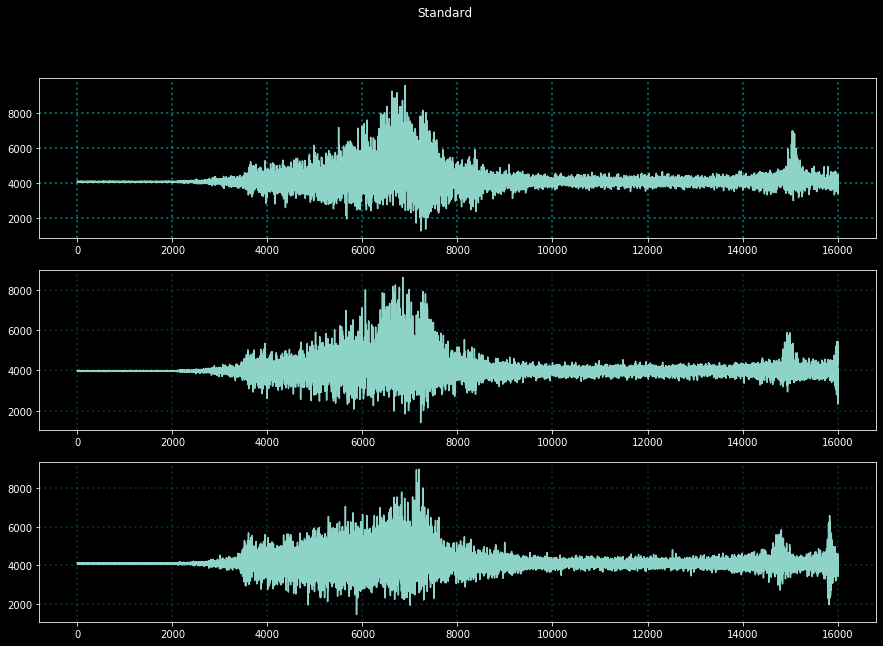

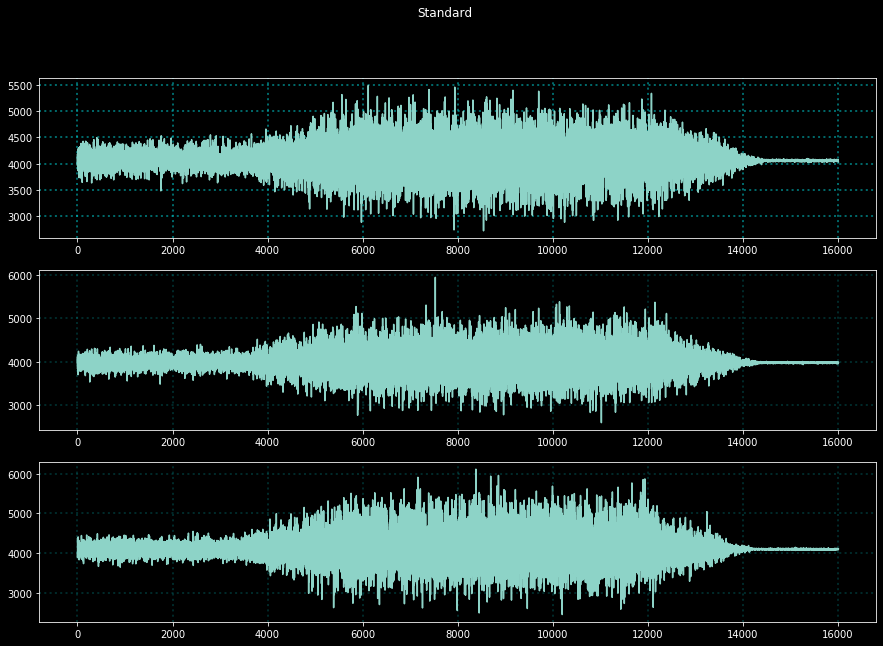

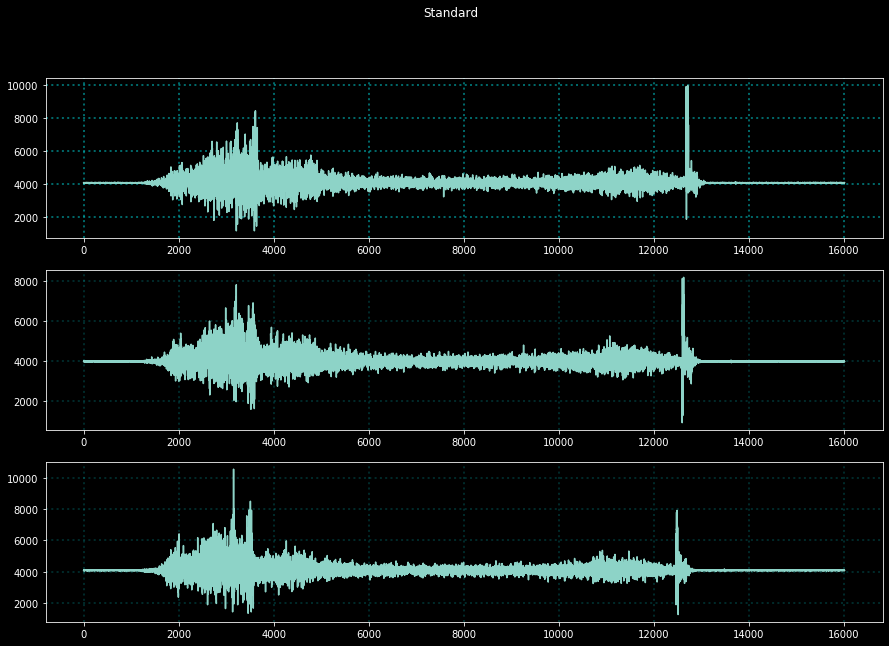

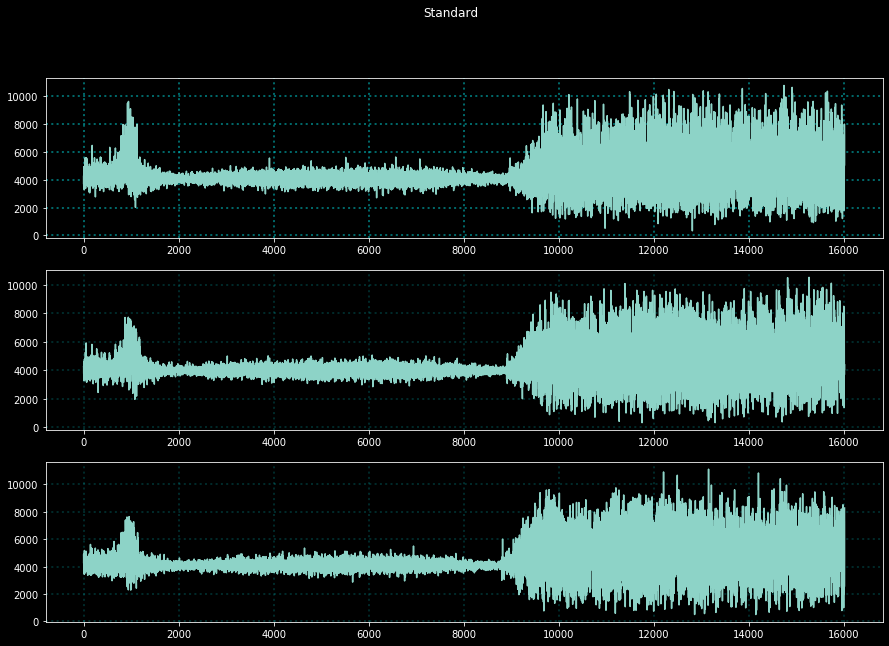

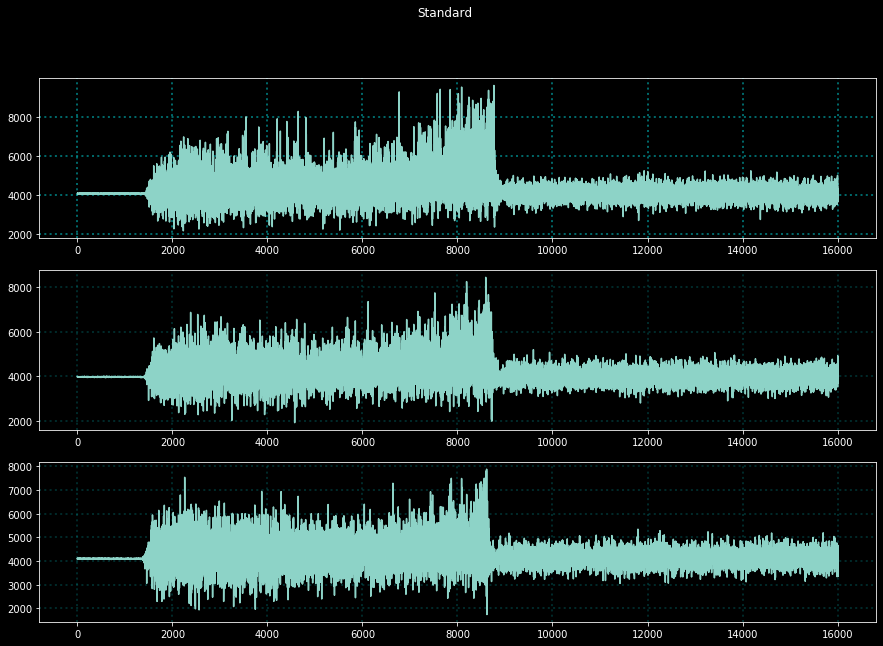

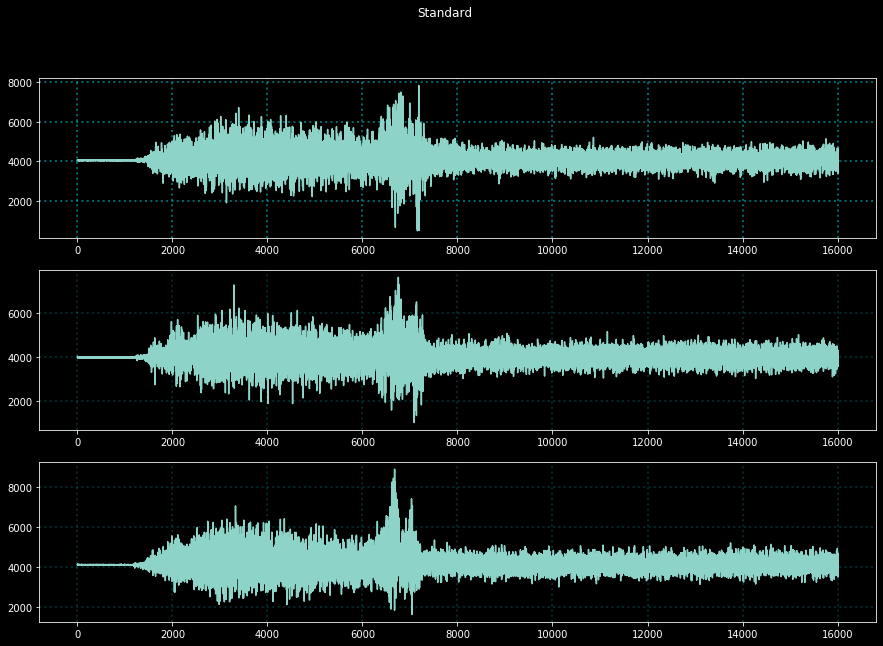

In [174]:
directory = "Meas_acc_flow/"
list_meas_1 = os.listdir(directory)
plt.rcParams['figure.figsize'] = [15, 10]
for file in list_meas_1:
    data_np, hpfEnable, flowRate = getDataFromFile(directory + file) 
    acc1 = np.sqrt(np.power(data_np[0,:],2)+np.power(data_np[1,:],2)+np.power(data_np[2,:],2))
    acc2 = np.sqrt(np.power(data_np[3,:],2)+np.power(data_np[4,:],2)+np.power(data_np[5,:],2))
    acc3 = np.sqrt(np.power(data_np[6,:],2)+np.power(data_np[7,:],2)+np.power(data_np[8,:],2))
    fig, (acc1_x, acc1_y, acc1_z) = plt.subplots(3, 1)
    fig.suptitle("Standard")
    acc1_x.plot(acc1)
    acc1_x.grid(b=True, color='DarkTurquoise', alpha=0.5, linestyle=':', linewidth=2)
    acc1_y.plot(acc2)
    acc1_y.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    acc1_z.plot(acc3)
    acc1_z.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    plt.show()